In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read csv
df_CA = pd.read_csv("archive/CAvideos.csv")
df_US = pd.read_csv("archive/USvideos.csv")
df_GB = pd.read_csv("archive/GBvideos.csv")

In [3]:
df_CA

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40876,sGolxsMSGfQ,18.14.06,HOW2: How to Solve a Mystery,Annoying Orange,24,2018-06-13T18:00:07.000Z,"annoying orange|""funny""|""fruit""|""talking""|""ani...",80685,1701,99,1312,https://i.ytimg.com/vi/sGolxsMSGfQ/default.jpg,False,False,False,🚨 NEW MERCH! http://amzn.to/annoyingorange 🚨➤ ...
40877,8HNuRNi8t70,18.14.06,Eli Lik Lik Episode 13 Partie 01,Elhiwar Ettounsi,24,2018-06-13T19:01:18.000Z,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",103339,460,66,51,https://i.ytimg.com/vi/8HNuRNi8t70/default.jpg,False,False,False,► Retrouvez vos programmes préférés : https://...
40878,GWlKEM3m2EE,18.14.06,KINGDOM HEARTS III – SQUARE ENIX E3 SHOWCASE 2...,Kingdom Hearts,20,2018-06-11T17:30:53.000Z,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",773347,25900,224,3881,https://i.ytimg.com/vi/GWlKEM3m2EE/default.jpg,False,False,False,Find out more about Kingdom Hearts 3: https://...
40879,lbMKLzQ4cNQ,18.14.06,Trump Advisor Grovels To Trudeau,The Young Turks,25,2018-06-13T04:00:05.000Z,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",115225,2115,182,1672,https://i.ytimg.com/vi/lbMKLzQ4cNQ/default.jpg,False,False,False,Peter Navarro isn’t talking so tough now. Ana ...


In [4]:
print(list(df_CA.columns.values))

['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']


In [5]:
print(len(df_CA), len(df_US), len(df_GB))

40881 40949 38916


In [6]:
df = pd.concat([df_CA , df_US, df_GB])
len(df)

120746

In [7]:
# only keep ['video_id', 'title', 'channel_title', 'category_id', 'description']
df = df[['video_id', 'title', 'category_id', 'tags','description']]

In [8]:
a = df['video_id'].isna().sum()
b = df['title'].isna().sum()
c = df['category_id'].isna().sum()
d = df['tags'].isna().sum()
e = df['description'].isna().sum()

print(a, b, c, d, e)

0 0 0 0 2478


In [9]:
df = df.dropna()
len(df)

118268

Identify a dataset to study, and perform an exploratory analysis of the data. Describe the dataset,
including its basic statistics and properties, and report any interesting findings. This exploratory analysis
should motivate the design of your model in the following sections

Text(0.5, 1.0, 'Distribution of Category IDs')

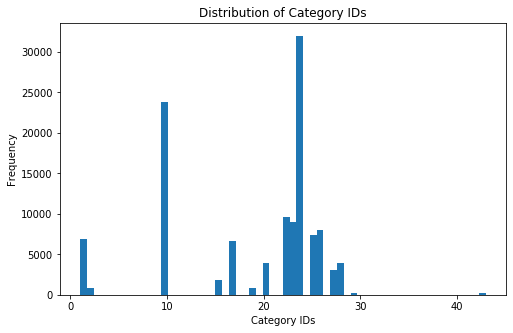

In [10]:
df['category_id'].plot.hist(bins = 60, figsize=(8,5))
plt.xlabel('Category IDs')
plt.ylabel('Frequency')
plt.title('Distribution of Category IDs')

In [11]:
cat_list = df['category_id'].to_list()

In [12]:
from collections import Counter

In [13]:
cat_counter = Counter(cat_list)
len(cat_counter.keys())

17

In [14]:
cat_counter.most_common(len(cat_counter.keys()))

[(24, 31972),
 (10, 23790),
 (22, 9605),
 (23, 8962),
 (26, 8059),
 (25, 7441),
 (1, 6896),
 (17, 6661),
 (28, 3980),
 (20, 3894),
 (27, 3081),
 (15, 1813),
 (19, 875),
 (2, 871),
 (43, 201),
 (29, 161),
 (30, 6)]

In [15]:
# unique vals
cat_counter.keys()

dict_keys([10, 23, 24, 25, 22, 26, 1, 28, 20, 17, 29, 15, 19, 2, 27, 43, 30])

In [16]:
print((cat_counter.most_common(1))[0][1]/len(cat_list))
print((cat_counter.most_common(2))[1][1]/len(cat_list))

0.2703351709676328
0.20115331281496263


/Users/luckilyclueless/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


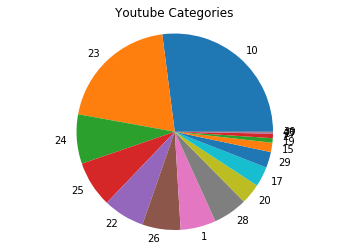

In [17]:
cats = df['category_id'].value_counts()
cat_chart = [cats]


my_labels = [str(key) for key in cat_counter.keys()]

plt.pie(cat_chart, labels=my_labels)

plt.title('Youtube Categories')
plt.axis('equal')

plt.show()

In [18]:
# getting rid of all ids after 17, the top 10
top_cats = cat_counter.keys()
top_cats = list(top_cats)[0:10]
top_cats = set(top_cats)
top_cats

{1, 10, 17, 20, 22, 23, 24, 25, 26, 28}

In [19]:
# df containing only the top 10
new_df = pd.DataFrame()

for cat in top_cats:
    new_df = pd.concat([new_df , df[df['category_id'] == cat] ]) 

In [20]:
len(new_df)

111260

In [21]:
cat_list = new_df['category_id'].to_list()
cat_counter = Counter(cat_list)
cat_counter.most_common(len(cat_counter.keys()))

[(24, 31972),
 (10, 23790),
 (22, 9605),
 (23, 8962),
 (26, 8059),
 (25, 7441),
 (1, 6896),
 (17, 6661),
 (28, 3980),
 (20, 3894)]

In [22]:
# the data to work with
df = new_df

In [23]:
df

,video_id,title,category_id,tags,description
12,FyZMnhUtLfE,猎场 | Game Of Hunting 12【TV版】（胡歌、張嘉譯、祖峰等主演）,1,"電視劇|""大陸電視劇""|""猎场""|""职场""|""商战""|""爱情""|""都市""|""胡歌""|""陈龙""...",Thanks for watching the drama! Help more peopl...
18,fy-CuCzaPp8,Rooster Teeth Animated Adventures - Drunk Baby...,1,"Rooster Teeth|""RT""|""animation""|""television""|""f...",Miles gets stuck at work one night watching ov...
19,kzwfHumJyYc,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,1,"sharry mann|""sharry mann new song""|""sharry man...",Presenting Sharry Mann latest Punjabi Song Cu...
45,-Toujzk3ysk,"Gerrymandering, Conservative Comedians, Bobby ...",1,"DNC Chairwoman Donna Brazile|""Hacks""|""The Insi...",Subscribe to the Real Time YouTube: http://its...
103,kOnQocd799Y,Everything Wrong With Baby Driver In 14 Minute...,1,"baby driver|""edgar wright""|""everything wrong w...","Here's a movie that most people, including us,..."
...,...,...,...,...,...
34642,QpFcf7uBacI,OnePlus 6 - The Speed You Need Live Launch Event,28,"oneplus|""oneplus6""",Witness the unveiling of the OnePlus 6 at the ...
34807,QpFcf7uBacI,OnePlus 6 - The Speed You Need Live Launch Event,28,"oneplus|""oneplus6""",Witness the unveiling of the OnePlus 6 at the ...
34966,QpFcf7uBacI,OnePlus 6 - The Speed You Need Live Launch Event,28,"oneplus|""oneplus6""",Witness the unveiling of the OnePlus 6 at the ...
35122,QpFcf7uBacI,OnePlus 6 - The Speed You Need Live Launch Event,28,"oneplus|""oneplus6""",Witness the unveiling of the OnePlus 6 at the ...


In [24]:
df.iloc[0]

video_id                                             FyZMnhUtLfE
title                 猎场 | Game Of Hunting 12【TV版】（胡歌、張嘉譯、祖峰等主演）
category_id                                                    1
tags           電視劇|"大陸電視劇"|"猎场"|"职场"|"商战"|"爱情"|"都市"|"胡歌"|"陈龙"...
description    Thanks for watching the drama! Help more peopl...
Name: 12, dtype: object